# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
### GOAL :
    Make a pipeline that finds lane lines on the road for basic understanding of concepts
    Reflect on your work in a written report

---

## Pipeline :
To achieve the first goal to find lane lines I am using canny edge detection technique.

**The main steps involved in canny edge detection are as follow:**

1. Grayscale Conversion
2. Gaussian Blur
3. Determine the Intensity Gradients
4. Non Maximum Suppression - thins the edges
5. Double Thresholding - reduces the noise (takes out some edges that were detected which were acually not present)
6. Edge Tracking by Hysteresis - to connect weak edges to strong ones

Steps followed for canny edge detction in this project :
1. Grayscle conversion using cv2
2. Gaussian Blur using cv2
3. Canny edge using cv2
    - Noise Reduction
    - Finding Intensity Gradient of the Image
    - Non-maximum Suppression
    - Hysteresis Thresholding
4. Masking area of interest
5. Hough Lines - to identify the lane lines
6. addWeighted function - to show lines on the original image

---
Here it is what to expect after completion of pipeline :
<figure>
 <img src="test_images/solidWhiteRight.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Before pipeline process </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> After pipeline process</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


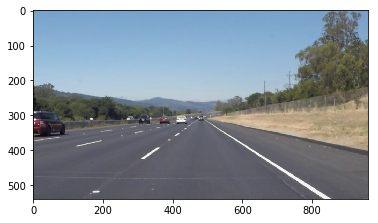

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


ymax_left_g=539
ymin_left_g=0

xmax_left_g=0
xmin_left_g=0

ymax_right_g=539
ymin_right_g=0

xmax_right_g=0
xmin_right_g=0
counter=0
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope1=0
    slope2=0
    count1=0
    count2=0
    left_x=[]
    left_y=[]
    right_x=[]
    right_y=[]
    
    global counter
    
    global ymax_left_g
    global ymin_left_g
    
    global xmax_left_g
    global xmin_left_g

    global ymax_right_g
    global ymin_right_g
    
    global xmax_right_g
    global xmin_right_g
    for vertices in lines :
        slope=(vertices[0][3]-vertices[0][1])/(vertices[0][2]-vertices[0][0])
        #print('Slope : ', slope )
        #print('Slope : ', (lines[3]-vertices[1])/(vertices[2]-vertices[0]) )
        #print('vertices : ' , vertices) #==========================

        if abs(slope)<0.4 or abs(slope)>0.7:
            # Ignore invalid lines
            #cv2.line(img, (xmin_left_g, ymin_left_g), (xmax_left_g, ymax_left_g), color, thickness)
            #cv2.line(img, (xmin_right_g,ymin_right_g), (xmax_right_g, ymax_right_g), color, thickness)
            continue
        elif slope>0 :
            slope1=slope1+round(slope, 4)
            count1=count1+1
            left_x.append(vertices[0][0])
            left_x.append(vertices[0][2])
            left_y.append(vertices[0][1])
            left_y.append(vertices[0][3])
        else :
            slope2=slope2+round(slope,4)
            count2=count2+1
            right_x.append(vertices[0][0])
            right_x.append(vertices[0][2])
            right_y.append(vertices[0][1])
            right_y.append(vertices[0][3])
        
    if len(left_x)==0 and len(right_x)==0 :
        #right line
        cv2.line(img, (xmin_left_g, ymin_left_g), (xmax_left_g, ymax_left_g), color, thickness)
        #left line
        cv2.line(img, (xmin_right_g,ymin_right_g), (xmax_right_g, ymax_right_g), color, thickness)
    elif len(left_x)==0 :
        slope_c_right=np.polyfit(right_x,right_y,1)
        ymax_right=539
        ymin_right=np.min(right_y)

        xmax_right= int((ymax_right-slope_c_right[1])/slope_c_right[0])
        xmin_right= int((ymin_right-slope_c_right[1])/slope_c_right[0])
        
        #right line
        cv2.line(img, (xmin_left_g, ymin_left_g), (xmax_left_g, ymax_left_g), color, thickness)
        #left line
        cv2.line(img, (xmin_right,ymin_right), (xmax_right, ymax_right), color, thickness)
    elif len(right_x)==0:
        slope_c_left=np.polyfit(left_x,left_y,1)
        ymax_left=539
        ymin_left=np.min(left_y)

        xmax_left= int((ymax_left-slope_c_left[1])/slope_c_left[0])
        xmin_left= int((ymin_left-slope_c_left[1])/slope_c_left[0])

        #right line
        cv2.line(img, (xmin_left, ymin_left), (xmax_left, ymax_left), color, thickness)
        #left line
        cv2.line(img, (xmin_right_g,ymin_right_g), (xmax_right_g, ymax_right_g), color, thickness)
    else:
        slope_c_left=np.polyfit(left_x,left_y,1)
        ymax_left=539
        ymin_left=325 #np.min(left_y)

        xmax_left= int((ymax_left-slope_c_left[1])/slope_c_left[0])
        xmin_left= int((ymin_left-slope_c_left[1])/slope_c_left[0])

        slope_c_right=np.polyfit(right_x,right_y,1)
        ymax_right=539
        ymin_right=325 #np.min(right_y)

        xmax_right= int((ymax_right-slope_c_right[1])/slope_c_right[0])
        xmin_right= int((ymin_right-slope_c_right[1])/slope_c_right[0])

        ymax_left_g=ymax_left
        ymin_left_g=ymin_left

        xmax_left_g=xmax_left
        xmin_left_g=xmin_left

        ymax_right_g=ymax_right
        ymin_right_g=ymin_right

        xmax_right_g=xmax_right
        xmin_right_g=xmin_right

        counter=1
        #right line
        cv2.line(img, (xmin_left, ymin_left), (xmax_left, ymax_left), color, thickness)
        #left line
        cv2.line(img, (xmin_right,ymin_right), (xmax_right, ymax_right), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
      
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

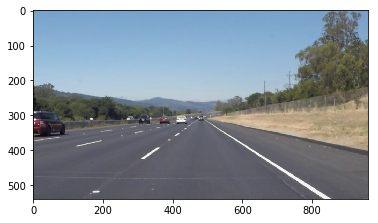

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

plt.imshow(image)
plt.figure() #to print multiple images

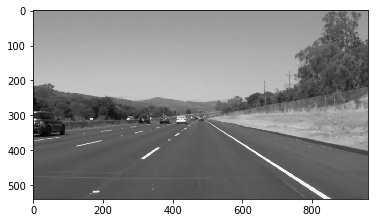

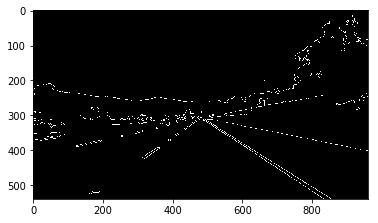

In [6]:
#image_working= np.copy(image) #to copy an image

gray = grayscale(image) #grayscale conversion
plt.imshow(gray, cmap='gray')
plt.figure() #multiple images in same output
kernel_size = 7
blur_gray = gaussian_blur(gray,kernel_size)

#setting threshold values
highThreshold = 180*0.7;
lowThreshold = highThreshold*0.3;

edges=cv2.Canny(blur_gray,lowThreshold,highThreshold)
plt.imshow(edges, cmap='gray')



960


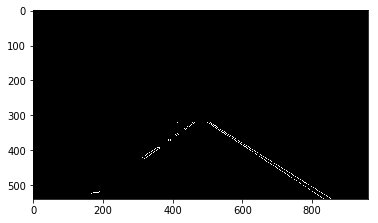

In [7]:
## perform the region_of_interest, here or earlier
#taking region_of_interest as traiangle

upper_left=[400,320]
upper_right=[550,320]
left_bottom=[150,539]
right_bottom=[900,539]
triangle = np.array([ upper_left, left_bottom , right_bottom,upper_right])
masked_image=region_of_interest(edges,[triangle])
plt.imshow(masked_image,cmap='gray')
print (image.shape[1])

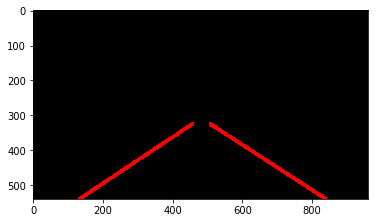

In [8]:
#hough_transform, hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
image_hough=hough_lines(masked_image,2,np.pi/180,25,25,10)

plt.imshow(image_hough,cmap='gray')

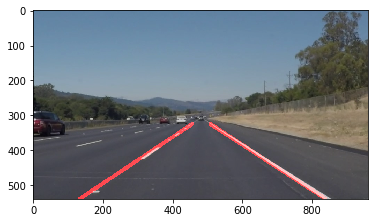

In [9]:
#weighted_img

w_img=weighted_img(image_hough,image)
plt.imshow(w_img,cmap='gray')
mpimg.imsave("test-after.png", w_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Reading in an image from video clip

221
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


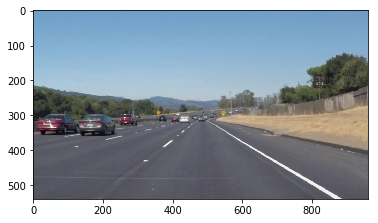

In [11]:
#reading in an image from video clip
clipTest = VideoFileClip('test_videos/solidWhiteRight.mp4')
#clipTest = VideoFileClip('test_videos/solidYellowLeft.mp4')

n_frames = sum(1 for x in clipTest.iter_frames())

print(n_frames)
count=0
for frame in clipTest.iter_frames():
    count=count+1
    if count==174:
        image=frame
        break
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [12]:
def process_image(image):


    gray = grayscale(image) #grayscale conversion
    kernel_size = 7
    blur_gray = gaussian_blur(gray,kernel_size) #gaussian blur

    #setting threshold values
    highThreshold = 180*0.7;
    lowThreshold = highThreshold*0.3;

    edges=cv2.Canny(blur_gray,lowThreshold,highThreshold) #canny edge
    #plt.imshow(edges, cmap='gray')

    upper_left=[450,320]
    upper_right=[550,320]
    left_bottom=[130,539]
    right_bottom=[900,539]
    mask_area = np.array([ upper_left, left_bottom , right_bottom,upper_right])
    masked_image=region_of_interest(edges,[mask_area])

    #hough_transform, hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    image_hough=hough_lines(masked_image,2,np.pi/180,25,25,5)
    
    #weighted_img -print line detected on top of original image

    result=weighted_img(image_hough,image)
    return result




Let's try the one with the solid white lane on the right first ...

In [13]:
global counter
counter=0
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:08<00:00, 25.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
global counter
counter=0
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:31<00:00, 21.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 33.1 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections and Thoughts

There are number of ways in which the current implementation of pipelines can be improved. A running average of the lane lines can be maintained in case an erroneous frame appears. Pipeline process here does not take into account the dark and light patches on the road due to shadows, rains etc. An approach to this can be included in the pipeline process.

Running average can be implemented by storing the values as global variables. To take care of light and dark patches we can work on hsv colorspace.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
'''challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)'''

"challenge_output = 'test_videos_output/challenge.mp4'\n## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video\n## To do so add .subclip(start_second,end_second) to the end of the line below\n## Where start_second and end_second are integer values representing the start and end of the subclip\n## You may also uncomment the following line for a subclip of the first 5 seconds\n##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)\nclip3 = VideoFileClip('test_videos/challenge.mp4')\nchallenge_clip = clip3.fl_image(process_image)\n%time challenge_clip.write_videofile(challenge_output, audio=False)"

In [18]:
'''HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))'''

'HTML("""\n<video width="960" height="540" controls>\n  <source src="{0}">\n</video>\n""".format(challenge_output))'